<a href="https://colab.research.google.com/github/martykihn/xmas_movies_analysis/blob/main/LDA_with_Parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import spacy

In [ ]:
# this code is just for Google Colab notebook word wrapping format

from IPython.display import HTML, display
def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/MyDrive'

/content/drive/MyDrive


In [ ]:
cd 'Colab Notebooks/TextFiles'

/content/drive/MyDrive/Colab Notebooks/TextFiles


In [ ]:
plots = []
with open('/content/drive/MyDrive/Colab Notebooks/TextFiles/doclist_minus_xmas.txt') as myfile:
  for plot in myfile:
    plot = plot.replace('\n', '')
    if plot == '':
      continue
    else:
      plots.append(str(plot))
myfile.close()

In [ ]:
len(plots)

260

In [ ]:
# turn list of strings into list of lists(words)
temp2 = [plot.split() for plot in plots]

In [ ]:
#temp2 is list of lists of words in plots

In [ ]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in temp2:
        doc = nlp(' '.join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
#make bigrams
import gensim
from gensim import models

bigram = gensim.models.Phrases(temp2, min_count=2, threshold=20)

In [ ]:
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = stopwords.words('english')

def remove_stopwords(texts):
    return[[word for word in doc if word not in stop_words] for doc in temp2]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in temp2]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
data_words_nostops = remove_stopwords(temp2)
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
import gensim.corpora as corpora
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=10,
                                      random_state=100,
                                      chunksize=20,
                                      passes=10,
                                      per_word_topics=True)

In [ ]:
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

In [ ]:
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.30744280738131186


In [ ]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                          id2word=dictionary,
                                          num_topics=k,
                                          random_state=100,
                                          chunksize=20,
                                          passes=10,
                                          alpha=a,
                                          eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}

min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

#alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

#beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

In [ ]:
#validation sets
num_of_docs = len(corpus)
corpus_sets = [
    # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
    # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5),
    # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75),
    corpus
    ]

corpus_title = ['100% Corpus']

model_results = {'Validation_Set': [],
                'Topics': [],
                'Alpha': [],
                'Beta': [],
                'Coherence': []
                }

In [ ]:
import pandas as pd

In [ ]:
if 1 == 1:
    pbar = tqdm.tqdm()
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # through topics
        for k in topics_range:
            # through alpha values
            for a in alpha:
                # through beta values
                for b in beta:
                    #get coherence score
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, k=k, a=a, b=b)
                    
# same model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)

                    pbar.update(1)

    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
270it [11:44,  2.61s/it]


In [ ]:
df_lda_tuning = pd.read_csv("lda_tuning_results.csv")

In [ ]:
df_lda_tuning

,Validation_Set,Topics,Alpha,Beta,Coherence
0,100% Corpus,2,0.01,0.01,0.267088
1,100% Corpus,2,0.01,0.31,0.328469
2,100% Corpus,2,0.01,0.61,0.305459
3,100% Corpus,2,0.01,0.9099999999999999,0.343533
4,100% Corpus,2,0.01,symmetric,0.316129
...,...,...,...,...,...
265,100% Corpus,10,asymmetric,0.01,0.327373
266,100% Corpus,10,asymmetric,0.31,0.401871
267,100% Corpus,10,asymmetric,0.61,0.370544
268,100% Corpus,10,asymmetric,0.9099999999999999,0.392762


In [ ]:
# visualize coherence by topic for alpha=0.01 and beta=0.1

temp = df_lda_tuning[(df_lda_tuning['Alpha'] == '0.01') & (df_lda_tuning['Beta'] == '0.01')]

In [ ]:
df_lda_tuning.describe

<bound method NDFrame.describe of     Validation_Set  Topics       Alpha                Beta  Coherence
0      100% Corpus       2        0.01                0.01   0.267088
1      100% Corpus       2        0.01                0.31   0.328469
2      100% Corpus       2        0.01                0.61   0.305459
3      100% Corpus       2        0.01  0.9099999999999999   0.343533
4      100% Corpus       2        0.01           symmetric   0.316129
..             ...     ...         ...                 ...        ...
265    100% Corpus      10  asymmetric                0.01   0.327373
266    100% Corpus      10  asymmetric                0.31   0.401871
267    100% Corpus      10  asymmetric                0.61   0.370544
268    100% Corpus      10  asymmetric  0.9099999999999999   0.392762
269    100% Corpus      10  asymmetric           symmetric   0.365306

[270 rows x 5 columns]>

In [ ]:
temp

,Validation_Set,Topics,Alpha,Beta,Coherence
0,100% Corpus,2,0.01,0.01,0.267088
30,100% Corpus,3,0.01,0.01,0.330309
60,100% Corpus,4,0.01,0.01,0.280666
90,100% Corpus,5,0.01,0.01,0.292461
120,100% Corpus,6,0.01,0.01,0.296803
150,100% Corpus,7,0.01,0.01,0.290028
180,100% Corpus,8,0.01,0.01,0.279136
210,100% Corpus,9,0.01,0.01,0.290939
240,100% Corpus,10,0.01,0.01,0.292030


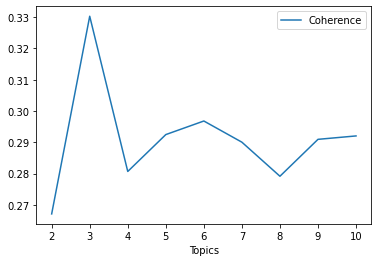

In [ ]:
temp.plot(x = 'Topics', y = 'Coherence')

In [ ]:
# seems to peak at 3 topics - we will use that number

lda_3_topics = df_lda_tuning[df_lda_tuning['Topics'] == 3]

In [ ]:
lda_3_topics.sort_values(by='Coherence', ascending=False)

,Validation_Set,Topics,Alpha,Beta,Coherence
57,100% Corpus,3,asymmetric,0.61,0.457634
52,100% Corpus,3,symmetric,0.61,0.398292
37,100% Corpus,3,0.31,0.61,0.398292
58,100% Corpus,3,asymmetric,0.9099999999999999,0.394118
32,100% Corpus,3,0.01,0.61,0.389386
38,100% Corpus,3,0.31,0.9099999999999999,0.373962
53,100% Corpus,3,symmetric,0.9099999999999999,0.370122
48,100% Corpus,3,0.9099999999999999,0.9099999999999999,0.354788
55,100% Corpus,3,asymmetric,0.01,0.349766
31,100% Corpus,3,0.01,0.31,0.348468


In [ ]:
# so optimal model parameters are Topics = 3, Alpha='asymmetric' Beta = 0.6

In [ ]:
# final model with these parameters

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=3,
                                       random_state=100,
                                       chunksize=20,
                                       passes=10,
                                       alpha='asymmetric',
                                       eta=0.6)

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7MB 5.5MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=21cc8c1c2baef9404b70c912e02967879ca117e617c433ff178225fd55a41584
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis


In [ ]:
# visualize topics
import pyLDAvis.gensim
import pickle
import pyLDAvis

pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.113794 -0.000034       1        1  79.868829
1     -0.056982 -0.034141       2        1  13.231277
2     -0.056812  0.034175       3        1   6.899894, topic_info=               Term       Freq      Total Category  logprob  loglift
34             show  12.000000  12.000000  Default  30.0000  30.0000
1102    celebration   9.000000   9.000000  Default  29.0000  29.0000
336            real   7.000000   7.000000  Default  28.0000  28.0000
922          travel   6.000000   6.000000  Default  27.0000  27.0000
810           offer   7.000000   7.000000  Default  26.0000  26.0000
...             ...        ...        ...      ...      ...      ...
816            wake   0.846247   3.042133   Topic3  -6.1826   1.3942
272            will   0.912848   4.626203   Topic3  -6.1068   1.0507
1040  christmastime   0.818284   4.096721   Topic3  -6.2162   1.0629
915          aspire   0.764891   2.555227   Topic3  -6.2837   1.4675
697       assistant   0.753771   2.512909   Topic3  -6.2983   1.4696

[157 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1764      1  0.565941  american
1764      3  0.565941  american
915       1  0.391355    aspire
915       2  0.391355    aspire
915       3  0.391355    aspire
...     ...       ...       ...
147       1  0.996069      year
79        1  0.944734     young
79        2  0.049723     young
553       1  0.976013         ’
553       2  0.037539         ’

[235 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])